In [1]:
%pip install requests pandas numpy matplotlib seaborn scipy==1.4.1 cvxpy openpyxl scikit-learn SyntheticControlMethods

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


BS - FIDR_PA - M
{'@TIME_PERIOD': '1985-01', '@OBS_VALUE': '7.42'}
{'@TIME_PERIOD': '2023-12', '@OBS_VALUE': '0.55'}


/var/folders/9x/p8jlzgy11cv4_f8srk_0w80w0000gn/T/ipykernel_30607/603798080.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recentval = round(df[-1], 1)


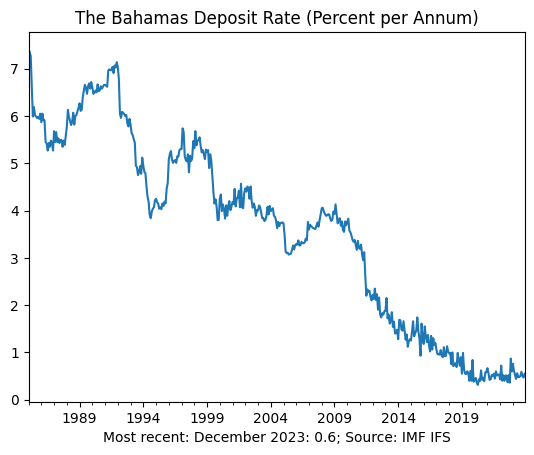

In [80]:
import requests # Python 3.6
import pandas as pd # pandas version 0.23

# The Bahamas

FREQUENCY = 'M' # 'M' for monthly, 'Q' for quarterly, 'A' for annual
COUNTRY = 'BS' # ISO country code
INDICATOR = 'FIDR_PA' # 'FIDR_PA' for Interest Rates, Deposit Interest

url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = f'CompactData/IFS/{FREQUENCY}.{COUNTRY}.{INDICATOR}'

# Navigate to series in API-returned JSON data
data = (requests.get(f'{url}{key}').json()
        ['CompactData']['DataSet']['Series'])

print(f"{COUNTRY} - {INDICATOR} - {FREQUENCY}")
print(data['Obs'][0]) # Print first observation
print(data['Obs'][-1]) # Print latest observation

# Create pandas dataframe from the observations
data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
             for obs in data['Obs']]

df = pd.DataFrame(data_list, columns=['date', 'value'])
df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

# Save cleaned dataframe as a csv file
df.to_csv(f'data/{FREQUENCY}-{COUNTRY}-{INDICATOR}.csv', header=True)

# Title and text with recent value
title = 'The Bahamas Deposit Rate (Percent per Annum)'
recentdt = df.index[-1].strftime('%B %Y')
recentval = round(df[-1], 1)
recent = f'Most recent: {recentdt}: {recentval}'
source = 'Source: IMF IFS'

# Basic plot
plot = df.plot(title=title)
plot = plot.set_xlabel(f'{recent}; {source}')

In [21]:
import sys
# import requests # Python 3.6
import pandas as pd # pandas version 0.23

# The Bahamas
TREATMENT_UNIT = 'BS'
# Antigua and Barbuda, Barbados, Belize, Dominica, Fiji, Grenada, Mauritius, Seychelles, Cayman Islands, Jamaica, Saint Kitts and Nevis, Saint Lucia, Saint Vincent and the Grenadines, British Virgin Islands, Trinidad and Tobago
CONTROL_UNITS = ['AG', 'BB', 'BZ', 'DM', 'FJ', 'GD', 'MU', 'SC', 'KY', 'JM', 'KN', 'LC', 'VC', 'VG', 'TT']
COUNTRIES = [TREATMENT_UNIT] + CONTROL_UNITS

# Deposits Interest Rate
OUTPUT = 'FIDR_PA'
# GDP, Inflation Rate, Treasury Bills, Central Bank Policy Rate, Savings Rate, Lending Rate
INPUTS = ['NGDP_XDC', 'PCPI_IX', 'FITB_PA', 'FPOLM_PA', 'FISR_PA', 'FILR_PA']
# INPUTS = ['NGDP_XDC', 'NGDP_R_XDC', 'NGDP_R_NSA_XDC', 'PCPI_IX', 'FITB_PA', 'FPOLM_PA', 'FISR_PA', 'FILR_PA']
INDICATORS = [OUTPUT] + INPUTS

# IMF DATA API
URL = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
FREQUENCY = 'M' # 'M' for monthly, 'Q' for quarterly, 'A' for annual

# # IMF OTHER API
# URLv1 = 'https://www.imf.org/external/datamapper/api/v1/'
# COUNTRY = 'BHS' # ISO country code
# INDICATOR = 'NGDP_RPCH' # 'NGDP_RPCH' for GDP Change; 'PCPIEPCH' for CPI Change

# print(f"Getting data for {COUNTRY} - {INDICATOR}")

# key = f'{INDICATOR}/{COUNTRY}'

# # Make the request
# response = requests.get(f'{URLv1}{key}')

# if response.status_code != 200:
#     print(f"Failed to retrieve data for {country} - {indicator}; Response code: {response.status_code}")

# print(response.json())
# sys.exit(0)

data = {}
dataframe = pd.DataFrame(columns=(['code', 'country', 'year'] + INDICATORS))
print(dataframe, '\n')
code = 0
for country in COUNTRIES:
    code += 1
    df_country = pd.DataFrame
    data[country] = {}

    data_country = [[code, country, year]
                    for year in range(2013, 2024)]
    print(data_country)

    for indicator in INDICATORS:
        print(f"Getting data for {country} - {indicator}")

        key = f'CompactData/IFS/{FREQUENCY}.{country}.{indicator}?PeriodStart=2013,PeriodEnd=2024'

        # Make the request
        response = requests.get(f'{URL}{key}')

        if response.status_code != 200:
            print(f"Failed to retrieve data for {country} - {indicator}; Response code: {response.status_code}")
            continue

        try:
            imf_data = response.json()['CompactData']['DataSet']['Series']
        except KeyError as e:
            print(f"Failed to retrieve data for {country} - {indicator}; KeyError: ", e)
            continue
        except Exception as e:
            print(f"Failed to retrieve data for {country} - {indicator}; Error: ", e)
            continue

        # print(imf_data['Obs'][0]) # Print first observation
        # print(imf_data['Obs'][-1]) # Print latest observation

        # Create pandas dataframe from the observations
        data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')] for obs in imf_data['Obs']]

        df = pd.DataFrame(data_list, columns=['date', 'value'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df = df.set_index(pd.to_datetime(df['date']))
        # df = pd.DataFrame(data_list, columns=['date', 'value'])
        # df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

        # Calculate the percentage change
        df['percent_change'] = df['value'].pct_change() * 100

        # Save cleaned up dataframe as a csv file
        # print(df)
        df.to_csv(f'data/{country}-{indicator}-{FREQUENCY}.csv', header=True)

        # Store the percentage change DataFrame in the dictionary
        data[country][indicator] = df
        dataframe[indicator] = df['value']

        print(f"Data and percentage changes for {country} - {indicator} retrieved and saved.")

# print(data)

# # Title and text with recent value
# title = 'The Bahamas Deposit Rate (Percent per Annum)'
# recentdt = df.index[-1].strftime('%B %Y')
# recentval = round(df[-1], 1)
# recent = f'Most recent: {recentdt}: {recentval}'
# source = 'Source: IMF IFS'

# # Basic plot
# plot = df.plot(title=title)
# plot = plot.set_xlabel(f'{recent}; {source}')

Empty DataFrame
Columns: [code, country, year, FIDR_PA, NGDP_XDC, PCPI_IX, FITB_PA, FPOLM_PA, FISR_PA, FILR_PA]
Index: [] 

[[1, 'BS', 2013], [1, 'BS', 2014], [1, 'BS', 2015], [1, 'BS', 2016], [1, 'BS', 2017], [1, 'BS', 2018], [1, 'BS', 2019], [1, 'BS', 2020], [1, 'BS', 2021], [1, 'BS', 2022], [1, 'BS', 2023]]


AttributeError: module 'pandas' has no attribute 'from_csv'

In [28]:
import requests
import pandas as pd
import numpy as np

# The Bahamas
TREATMENT_UNIT = 'BS'
# Antigua and Barbuda, Barbados, Belize, Dominica, Fiji, Grenada, Mauritius, Saint Vincent and the Grenadines, Trinidad and Tobago
CONTROL_UNITS = ['AG', 'BB', 'BZ', 'DM', 'FJ', 'GD', 'MU', 'VC', 'TT']
COUNTRIES = [TREATMENT_UNIT] + CONTROL_UNITS

# Deposits Interest Rate
OUTPUT = 'FIDR_PA'
# GDP, Inflation Rate, Treasury Bills, Central Bank Policy Rate, Savings Rate, Lending Rate
INPUTS = ['NGDP_XDC', 'PCPI_IX', 'FITB_PA', 'FISR_PA', 'FILR_PA']
INDICATORS = [OUTPUT] + INPUTS

# IMF DATA API
URL = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
FREQUENCY = 'A' # 'M' for monthly, 'Q' for quarterly, 'A' for annual

years_range = list(map(str, range(2013, 2024)))  # Adjust the years as needed

# Initialize the master DataFrame
columns = ['code', 'country', 'year'] + INDICATORS
master_df = pd.DataFrame(columns=columns)

code = 1
# Fetch data for each country and indicator
for country in COUNTRIES:
    country_data = {year: {indicator: np.nan for indicator in INDICATORS} for year in years_range}  # Initialize with NaNs

    for indicator in INDICATORS:
        key = f'CompactData/IFS/{FREQUENCY}.{country}.{indicator}?startPeriod=2013&endPeriod=2024'
        response = requests.get(f'{URL}{key}')

        if response.status_code == 200:
            try:
                indicator_data = response.json()['CompactData']['DataSet']['Series']['Obs']
                print(indicator_data[0])
                print(indicator_data[-1])

                for obs in indicator_data:
                    country_data[obs['@TIME_PERIOD']][indicator] = obs['@OBS_VALUE']

                print(f"Successfully retrieved {country}.{indicator}")

            except Exception as e:
                print(f"Error processing {country}.{indicator}: {e}")
                # sys.exit(1)
        else:
            print(f"Failed to retrieve data for {country}.{indicator}; Response code: {response.status_code}")

    # Convert the nested dictionary to a DataFrame
    temp_df = pd.DataFrame.from_dict(country_data, orient='index', columns=INDICATORS)

    # Convert string values to numeric
    for indicator in INDICATORS:
        temp_df[indicator] = pd.to_numeric(temp_df[indicator], errors='coerce')

    # Calculate growth change for NGDP_XDC and PCPI_IX
    for growth_indicator in ['NGDP_XDC', 'PCPI_IX']:
        # temp_df[growth_indicator] = pd.to_numeric(temp_df[growth_indicator], errors='coerce')
        temp_df[growth_indicator] = temp_df[growth_indicator].pct_change() * 100

    # Convert the nested dictionary to a DataFrame
    # temp_df = pd.DataFrame(country_data)
    temp_df.reset_index(inplace=True)
    temp_df.rename(columns={'index': 'year'}, inplace=True)
    temp_df['code'] = code
    temp_df['country'] = country

    code += 1

    # Reorder and rename columns to match the master DataFrame
    temp_df = temp_df[['code', 'country', 'year'] + INDICATORS]

    # Append to the master DataFrame
    master_df = pd.concat([master_df, temp_df], ignore_index=True)

    print(f"Successfully saved data for {country}")

# Save the master DataFrame to CSV
master_df.to_csv('data/economic-data-4.0.csv', index=False)


{'@TIME_PERIOD': '2013', '@OBS_VALUE': '1.68'}
{'@TIME_PERIOD': '2023', '@OBS_VALUE': '0.538333333333333'}
Successfully retrieved BS.FIDR_PA
{'@TIME_PERIOD': '2013', '@OBS_VALUE': '10394.5102970946'}
{'@TIME_PERIOD': '2022', '@OBS_VALUE': '12897.4219255009'}
Successfully retrieved BS.NGDP_XDC
{'@TIME_PERIOD': '2013', '@OBS_VALUE': '105.995507859611', '@OBS_STATUS': 'B'}
{'@TIME_PERIOD': '2022', '@OBS_VALUE': '126.347404647515'}
Successfully retrieved BS.PCPI_IX
{'@TIME_PERIOD': '2013', '@OBS_VALUE': '0.298616666666667'}
{'@TIME_PERIOD': '2023', '@OBS_VALUE': '2.90583333333333'}
Successfully retrieved BS.FITB_PA
{'@TIME_PERIOD': '2013', '@OBS_VALUE': '0.968333333333333'}
{'@TIME_PERIOD': '2023', '@OBS_VALUE': '0.284791666666667'}
Successfully retrieved BS.FISR_PA
{'@TIME_PERIOD': '2013', '@OBS_VALUE': '4.75'}
{'@TIME_PERIOD': '2023', '@OBS_VALUE': '4.25'}
Successfully retrieved BS.FILR_PA
Successfully saved data for BS
{'@TIME_PERIOD': '2013', '@OBS_VALUE': '3.04434917695378'}
{'@TIME_P

In [ ]:
import pandas as pd

# Load the dataset
file_path = '~/Downloads/synthetic-control-dataset.csv'
df = pd.read_csv(file_path)

# Ensure the 'year' column and any other relevant columns are sorted appropriately
df.sort_values(by=['code', 'year'], inplace=True)

# Calculate the growth rates for NGDP_XDC and PCPI_IX
# The pct_change() function calculates the percentage change between the current and a prior element
df['NGDP_XDC'] = df.groupby('code')['NGDP_XDC'].pct_change() * 100
df['PCPI_IX'] = df.groupby('code')['PCPI_IX'].pct_change() * 100

# Using log differences instead of percentage changes
# df['NGDP_XDC'] = np.log(df.groupby('country')['NGDP_XDC'].shift(0)) - np.log(df.groupby('country')['NGDP_XDC'].shift(1))
# df['PCPI_IX'] = np.log(df.groupby('country')['PCPI_IX'].shift(0)) - np.log(df.groupby('country')['PCPI_IX'].shift(1))


# Fill NaN values that result from pct_change() with 0 or another placeholder if necessary
df['NGDP_XDC'].fillna(0, inplace=True)
df['PCPI_IX'].fillna(0, inplace=True)

# Save the modified dataset
modified_file_path = '~/Downloads/synthetic-control-dataset-modified.csv'
df.to_csv(modified_file_path, index=False)

modified_file_path

In [79]:
# EXAMPLE CODE IMF DATA API

# import pandas as pd          # pandas version 0.23

# baseyr = data['@BASE_YEAR']  # Save the base year

# # Create pandas dataframe from the observations
# data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
#              for obs in data['Obs']]

# df = pd.DataFrame(data_list, columns=['date', 'value'])

# df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

# # Save cleaned dataframe as a csv file
# df.to_csv('data/UK_import_price_index.csv', header=True)

# # Title and text with recent value
# title = f'U.K. Import Prices (index, {baseyr})'
# recentdt = df.index[-1].strftime('%B %Y')
# recentval = round(df[-1], 1)
# recent = f'Most recent: {recentdt}: {recentval}'
# source = 'Source: IMF IFS'

# # Basic plot
# plot = df.plot(title=title, colormap='Set1')
# plot = plot.set_xlabel(f'{recent}; {source}')

In [5]:
%pip uninstall scipy -y
%pip install scipy==1.4.1

Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached scipy-1.4.1.tar.gz (24.6 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [306 lines of output]
      Ignoring numpy: markers 'python_version == "3.5" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23813D+01    |proj g|=  8.33333D-01

At iterate    3    f=  1.15605D+00    |proj g|=  8.69812D-01

At iterate    6    f=  1.11651D+00    |proj g|=  2.37195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8      9     13     0     1   1.110D-07   1.117D+00
  F =   1.1165107146696776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.94866D+00    |proj g|=  1.19360D-01
  ys=-2.945E-15  -gs= 5.983E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     81     25     2     4   3.834D-02   1.949D+00
  F =   1.9486579712230170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42753D+01    |proj g|=  9.99905D-01

At iterate    3    f=  1.15955D+00    |proj g|=  6.07553D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    6    f=  1.11771D+00    |proj g|=  1.94808D-01

At iterate    9    f=  1.11653D+00    |proj g|=  1.32264D-01

At iterate   12    f=  1.11652D+00    |proj g|=  9.31996D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     48     18     0     1   5.439D-01   1.117D+00
  F =   1.1165202267497309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02410D+01    |proj g|=  9.90662D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.

 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.12162D+00    |proj g|=  2.99192D-01

At iterate    9    f=  1.11651D+00    |proj g|=  5.41789D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     14     19     0     3   6.661D-08   1.117D+00
  F =   1.1165107146696773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25983D+00    |proj g|=  9.64164D-01

At iterate    3    f=  1.81204D+00    |proj g|=  9.13047D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    3    f=  1.83081D+00    |proj g|=  2.78825D-01

At iterate    6    f=  1.80951D+00    |proj g|=  8.52651D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     11     12     0     3   8.882D-08   1.810D+00
  F =   1.8095107547793949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61095D+01    |proj g|=  9.81186D-01

At iterate    3    f=  1.39454D+01    |proj g|=  2.40901D-01

At iter


 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.94883D+00    |proj g|=  1.19394D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    9    f=  1.94866D+00    |proj g|=  1.19360D-01
  ys=-2.945E-15  -gs= 5.983E-08 BFGS update SKIPPED

Fit classic Synthetic Control
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

      Weight
BB  0.430453
FJ  0.038035
GD  0.459283
TT  0.072229
    6     10     94     31     1     4   3.834D-02   1.949D+00
  F =   1.9486579712230170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


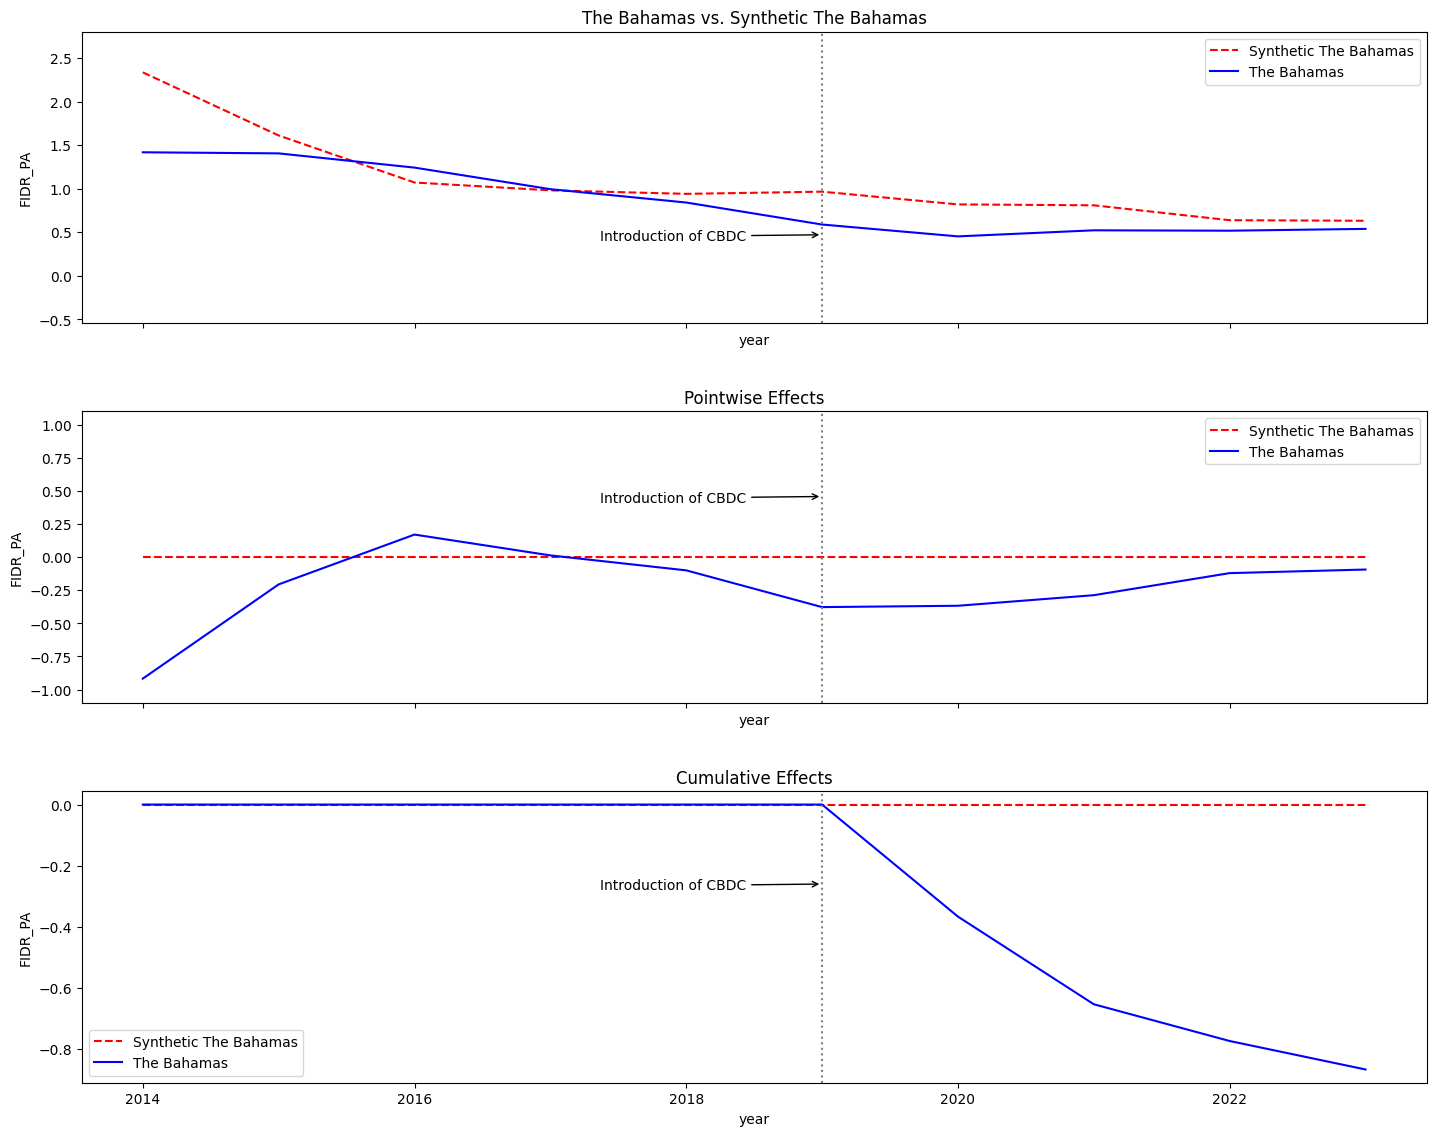

In [53]:
# SYNTHETIC CONTROL

#Import packages
import pandas as pd
from SyntheticControlMethods import Synth

#Import data
file_path = '~/Downloads/synthetic-control-dataset.csv'
data = pd.read_csv(file_path)
data = data.drop(columns="code", axis=1)

#Fit classic Synthetic Control
sc = Synth(data, "FIDR_PA", "country", "year", 2020, "BS", pen=0)

print("\nSynthetic Control Wieghts")
print(sc.original_data.weight_df)

#Visualize synthetic control
sc.plot(["original", "pointwise", "cumulative"], treated_label="The Bahamas", synth_label="Synthetic The Bahamas", treatment_label="Introduction of CBDC")

In [54]:
from pprint import pprint
pprint(vars(sc.original_data))

{'comparison_df':             BS  Synthetic BS  WMAPE  Importance
FIDR_PA   1.08          1.32   0.50         0.0
NGDP_XDC  3.89          3.81   2.24         1.0
PCPI_IX   1.55          1.52   1.02         0.0
FITB_PA   1.33          2.98   1.69         0.0
FISR_PA   0.71          2.06   1.42         0.0
FILR_PA   4.50          8.20   3.70         0.0,
 'control_covariates': array([[ 0.72716823,  0.33299442,  0.7372338 ,  0.85172692,  1.27967474,
         0.61148069,  2.01738731,  0.77814018,  0.44826468],
       [ 2.14027936,  0.94724952,  0.90080132,  1.51391935,  3.20359122,
         2.19552702,  2.24599216,  1.46589721, -0.65404853],
       [ 0.39349193,  1.02391178,  0.13867208,  0.19850515,  1.077163  ,
         0.15148426,  0.91464604,  0.23714168,  0.8624512 ],
       [ 1.44015698,  1.15876016,  0.19709551,  1.02145372,  0.64274624,
         1.35114865,  1.13656716,  1.16264043,  0.31976214],
       [ 0.88683378,  0.90443727,  0.76612584,  0.98655942,  0.44118594,
         0.87

In [ ]:
# EXAMPLE SYNTHETIC CONTROL

# #Import packages
# import pandas as pd
# from SyntheticControlMethods import Synth

# #Import data
# data = pd.read_csv("data/german-reunification-dataset.csv")
# data = data.drop(columns="code", axis=1)

# #Fit classic Synthetic Control
# sc = Synth(data, "gdp", "country", "year", 1990, "West Germany", pen=0)

# #Visualize synthetic control
# sc.plot(["original", "pointwise", "cumulative"], treated_label="West Germany", synth_label="Synthetic West Germany", treatment_label="German Reunification")